In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import theano.tensor as tt
import warnings

from scipy import stats
from scipy.stats import zscore
from itertools import product

import seaborn as sns

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
_BASE_URL = "https://raw.githubusercontent.com/rmcelreath/rethinking/master/data"
MILK_DATASET_PATH = f"{_BASE_URL}/milk.csv"

milk_data = pd.read_csv(MILK_DATASET_PATH, sep=";")
milk_data["log_mass"] = np.log(milk_data["mass"])
milk_data["neocortex.prop"] = milk_data["neocortex.perc"] * 100

In [3]:
milk_data[["kkals_z", "neocortex_prop_z", "log_mass_z"]] = milk_data[
    ["kcal.per.g", "neocortex.prop", "log_mass"]
].apply(zscore, nan_policy="omit")

In [4]:
milk_data_complete = milk_data.dropna()

In [5]:
# milk_data_ = milk_data_complete
milk_data_ = milk_data

In [6]:
with pm.Model() as model:
    sigma = pm.Exponential("sigma", 1)
    a = pm.Normal("a", 0, 0.5)
    bB = pm.Normal("bA", 0, 0.5)
    bM = pm.Normal("bM", 0, 0.5)
    nu = pm.Normal("nu", 0, 0.5)
    sigma_B = pm.Exponential("sigma_B", 5)
    B = pm.Normal("B", nu, sigma_B, observed=milk_data_["neocortex_prop_z"])
    mu = pm.Deterministic("mu", a + bM * milk_data_["log_mass_z"] + bB * B)
    K = pm.Normal("K", mu, sigma, observed=milk_data_["kkals_z"].values)

/home/worker/.local/share/virtualenvs/worker-Q7nhheP5/lib/python3.7/site-packages/pymc3/model.py:1430: ImputationWarning: Data in B contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


In [7]:
model

In [8]:
with model:
    trace = pm.sample(1000, tune=1000)
    # prior = pm.sample_prior_predictive(1000)
    posterior_predictive = pm.sample_posterior_predictive(trace)
    #pm_data = az.from_pymc3(
    #    trace=trace, prior=prior, posterior_predictive=posterior_predictive
    #)
    pm_data = az.from_pymc3(
        trace=trace, posterior_predictive=posterior_predictive
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [B_missing, sigma_B, nu, bM, bA, a, sigma]
100%|██████████| 2000/2000 [00:07<00:00, 253.69it/s]


/home/worker/.local/share/virtualenvs/worker-Q7nhheP5/lib/python3.7/site-packages/arviz/data/base.py:146: UserWarning: More chains (2000) than draws (17). Passed array should have shape (chains, draws, *shape)
  UserWarning,
/home/worker/.local/share/virtualenvs/worker-Q7nhheP5/lib/python3.7/site-packages/arviz/data/base.py:146: UserWarning: More chains (2000) than draws (29). Passed array should have shape (chains, draws, *shape)
  UserWarning,


Text(0, 0.5, 'kkals_z')

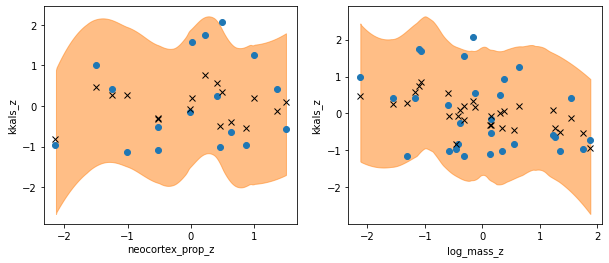

In [9]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)

y_hat = pm_data.posterior_predictive["K"].values.reshape(-1, 29).mean(axis=0)
m = ~np.isnan(milk_data_["neocortex_prop_z"])
az.plot_hpd(
    milk_data_["neocortex_prop_z"][m], pm_data.posterior_predictive["K"].values[:, :, m]
)
plt.plot(milk_data_["neocortex_prop_z"], milk_data_["kkals_z"], "o")
plt.plot(milk_data_["neocortex_prop_z"], y_hat, "x", color="k")
plt.gca().set_xlabel("neocortex_prop_z")
plt.gca().set_ylabel("kkals_z")
plt.subplot(1, 2, 2)
az.plot_hpd(milk_data_["log_mass_z"], pm_data.posterior_predictive["K"])
plt.plot(milk_data_["log_mass_z"], milk_data_["kkals_z"], "o")
plt.plot(milk_data_["log_mass_z"], y_hat, "x", color="k")
plt.gca().set_xlabel("log_mass_z")
plt.gca().set_ylabel("kkals_z")